In [1]:
import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, LSTM, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model

import pandas as pd
import numpy as np

import re
np.random.seed(5)

from sklearn import preprocessing
from sklearn.metrics import log_loss, classification_report

# for ploting graphs
import matplotlib.pyplot as plt
# advancec ploting
import seaborn as sns
# to create word clouds
from wordcloud import WordCloud, STOPWORDS 

# Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
# confusion matrix
from sklearn.metrics import confusion_matrix

# for deep learning 
import tensorflow as tf
# to tokenize text
from tensorflow.keras.preprocessing.text import Tokenizer
# to pad sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
# Análise de reviews do Smartwatch Amazfit Bip U Pro - Preto -  Amazon
df_texto = pd.read_csv('run_results2.csv')
df_texto.head(2)

,controle_review_curto,controle_review_longo,controle_nota,controle_nota_url,controle_selection1
0,Mais que recomendo!!!!,Que sensacional! O modelo da minha tv é uma da...,"5,0 de 5 estrelas",https://www.amazon.com.br/gp/customer-reviews/...,Avaliado no Brasil em 10 de maio de 2021
1,Não cumpre plenamente o que se propõe,Devo dizer que estou bem decepcionado.\nCompre...,"2,0 de 5 estrelas",https://www.amazon.com.br/gp/customer-reviews/...,Avaliado no Brasil em 13 de julho de 2021


In [3]:
df_texto.tail(2)

,controle_review_curto,controle_review_longo,controle_nota,controle_nota_url,controle_selection1
1508,Funcionalidades confirmadas.,O aparelho é realmente aquilo que esta descrit...,"5,0 de 5 estrelas",https://www.amazon.com.br/gp/customer-reviews/...,Avaliado no Brasil em 14 de fevereiro de 2022
1509,Não vale a pena.,Aparente parece um ótimo produto. Porém tem mu...,"1,0 de 5 estrelas",https://www.amazon.com.br/gp/customer-reviews/...,Avaliado no Brasil em 27 de janeiro de 2022


In [4]:
df_texto.drop('controle_nota_url', axis=1, inplace= True)
df_texto.head(2)

,controle_review_curto,controle_review_longo,controle_nota,controle_selection1
0,Mais que recomendo!!!!,Que sensacional! O modelo da minha tv é uma da...,"5,0 de 5 estrelas",Avaliado no Brasil em 10 de maio de 2021
1,Não cumpre plenamente o que se propõe,Devo dizer que estou bem decepcionado.\nCompre...,"2,0 de 5 estrelas",Avaliado no Brasil em 13 de julho de 2021


In [5]:
# Pré-processando os dados de datas.
meses=['janeiro',' fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
mesess = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
numeros=['0','1','2','3','4','5','6','7','8','9']
i=0
df_texto['data']=1

for datas in df_texto['controle_selection1']:
    if datas[23] in numeros:
        dia = datas[22:24]
    else:
        dia = datas[22]
    for mese in meses:
        if datas[28-len(datas):-8] in mese:
            mes = mesess[meses.index(mese)]
    ano = datas[-4:len(datas)]
    if '202' in datas:
        if '2021' in datas:
            ano = '2021'
        elif '2022' in datas:
            ano = '2022'
    
    df_texto['data'].iloc[i,:]=dia + "-" + mes + "-" + ano
    i=i+1

In [6]:
df_texto.head(60)

,controle_review_curto,controle_review_longo,controle_nota,controle_selection1,data
0,Mais que recomendo!!!!,Que sensacional! O modelo da minha tv é uma da...,"5,0 de 5 estrelas",Avaliado no Brasil em 10 de maio de 2021,10-05-2021
1,Não cumpre plenamente o que se propõe,Devo dizer que estou bem decepcionado.\nCompre...,"2,0 de 5 estrelas",Avaliado no Brasil em 13 de julho de 2021,13-07-2021
2,Não tem integração com toda TV,Eu comprei esse modelo justamente pelos botões...,"3,0 de 5 estrelas",Avaliado no Brasil em 15 de maio de 2021,15-05-2021
3,"O PRODUTO É ÓTIMO, MAS A ENTREGA FOI MEDONHA!!!","Pow, Amazon, que isso? vcs eram tão competente...","1,0 de 5 estrelas",Avaliado no Brasil em 27 de setembro de 2021,27-09-2021
4,Versátil,Pontos positivos: o processo de instalação é b...,"5,0 de 5 estrelas",Avaliado no Brasil em 17 de maio de 2021,17-05-2021
5,Muito Bom e rápido!,"Teclado na tela não é QWERT, e também o navega...","4,0 de 5 estrelas",Avaliado no Brasil em 7 de maio de 2021,7-05-2021
6,"ótimo produto, péssima logística para entrega ...","Gostei muito do produto, achei somente que o c...","1,0 de 5 estrelas",Avaliado no Brasil em 18 de agosto de 2021,18-08-2021
7,A Alexa não nos escuta se não apertamos o botã...,Sempre via em vídeos o pessoal falando com a A...,"5,0 de 5 estrelas",Avaliado no Brasil em 23 de outubro de 2021,23-10-2021
8,Fire Stick trava e conexão com Echo Studio é p...,O Fire Stick trava (aconteceu várias vezes) e ...,"3,0 de 5 estrelas",Avaliado no Brasil em 4 de julho de 2021,4-07-2021
9,ÓTIMA ESCOLHA!,Muito contente com o FIRE TV STICK da Amazon. ...,"5,0 de 5 estrelas",Avaliado no Brasil em 16 de novembro de 2021,16-11-2021


In [7]:
i=0
df_texto['nota']=1
for notas in df_texto['controle_nota']:
    df_texto['nota'].iloc[i,:]=notas[:1]
    i=i+1
    
df_texto.head(10)

,controle_review_curto,controle_review_longo,controle_nota,controle_selection1,data,nota
0,Mais que recomendo!!!!,Que sensacional! O modelo da minha tv é uma da...,"5,0 de 5 estrelas",Avaliado no Brasil em 10 de maio de 2021,10-05-2021,5
1,Não cumpre plenamente o que se propõe,Devo dizer que estou bem decepcionado.\nCompre...,"2,0 de 5 estrelas",Avaliado no Brasil em 13 de julho de 2021,13-07-2021,2
2,Não tem integração com toda TV,Eu comprei esse modelo justamente pelos botões...,"3,0 de 5 estrelas",Avaliado no Brasil em 15 de maio de 2021,15-05-2021,3
3,"O PRODUTO É ÓTIMO, MAS A ENTREGA FOI MEDONHA!!!","Pow, Amazon, que isso? vcs eram tão competente...","1,0 de 5 estrelas",Avaliado no Brasil em 27 de setembro de 2021,27-09-2021,1
4,Versátil,Pontos positivos: o processo de instalação é b...,"5,0 de 5 estrelas",Avaliado no Brasil em 17 de maio de 2021,17-05-2021,5
5,Muito Bom e rápido!,"Teclado na tela não é QWERT, e também o navega...","4,0 de 5 estrelas",Avaliado no Brasil em 7 de maio de 2021,7-05-2021,4
6,"ótimo produto, péssima logística para entrega ...","Gostei muito do produto, achei somente que o c...","1,0 de 5 estrelas",Avaliado no Brasil em 18 de agosto de 2021,18-08-2021,1
7,A Alexa não nos escuta se não apertamos o botã...,Sempre via em vídeos o pessoal falando com a A...,"5,0 de 5 estrelas",Avaliado no Brasil em 23 de outubro de 2021,23-10-2021,5
8,Fire Stick trava e conexão com Echo Studio é p...,O Fire Stick trava (aconteceu várias vezes) e ...,"3,0 de 5 estrelas",Avaliado no Brasil em 4 de julho de 2021,4-07-2021,3
9,ÓTIMA ESCOLHA!,Muito contente com o FIRE TV STICK da Amazon. ...,"5,0 de 5 estrelas",Avaliado no Brasil em 16 de novembro de 2021,16-11-2021,5


In [8]:
df_texto.dtypes

controle_review_curto    object
controle_review_longo    object
controle_nota            object
controle_selection1      object
data                     object
nota                      int64
dtype: object

In [9]:
df = df_texto[['controle_review_longo','data','nota']]
df.head(10)

,controle_review_longo,data,nota
0,Que sensacional! O modelo da minha tv é uma da...,10-05-2021,5
1,Devo dizer que estou bem decepcionado.\nCompre...,13-07-2021,2
2,Eu comprei esse modelo justamente pelos botões...,15-05-2021,3
3,"Pow, Amazon, que isso? vcs eram tão competente...",27-09-2021,1
4,Pontos positivos: o processo de instalação é b...,17-05-2021,5
5,"Teclado na tela não é QWERT, e também o navega...",7-05-2021,4
6,"Gostei muito do produto, achei somente que o c...",18-08-2021,1
7,Sempre via em vídeos o pessoal falando com a A...,23-10-2021,5
8,O Fire Stick trava (aconteceu várias vezes) e ...,4-07-2021,3
9,Muito contente com o FIRE TV STICK da Amazon. ...,16-11-2021,5


In [10]:
# Transformando tipo de dados das colunas
df['data'] = pd.to_datetime(df['data'], format="%d-%m-%Y")
df['nota'] =  df['nota'].astype(int)
df.dtypes

controle_review_longo            object
data                     datetime64[ns]
nota                              int32
dtype: object

In [11]:
df.tail(10)

,controle_review_longo,data,nota
1500,Gostei muito do produto. Para quem está em dec...,2021-12-27,5
1501,"Adorei meu fire Tv Stick com controle remoto, ...",2022-01-02,5
1502,Saudades do Chromecast.\nAparelho começou a ap...,2022-01-27,1
1503,"O controle perdeu a conexão,já tentei de tudo ...",2022-01-03,1
1504,"O Fire Stick é ótimo, mas infelizmente ainda n...",2021-08-24,4
1505,"Na pesquisa, os resultados deveriam ser aprese...",2021-11-30,4
1506,"O produto é sensacional, superou minhas expect...",2021-07-04,5
1507,O produto atende as expectativas. Muito fácil ...,2021-12-14,5
1508,O aparelho é realmente aquilo que esta descrit...,2022-02-14,5
1509,Aparente parece um ótimo produto. Porém tem mu...,2022-01-27,1


In [12]:
# Separando dados por niveis
escala = [
    (df["nota"] < 3),
    #(df["nota"] == 3),
    (df["nota"] >= 3)
         ]
nivel = ["Negativo",  "Positivo"]

df["Notas"] = np.select(escala, nivel)
df.head()

,controle_review_longo,data,nota,Notas
0,Que sensacional! O modelo da minha tv é uma da...,2021-05-10,5,Positivo
1,Devo dizer que estou bem decepcionado.\nCompre...,2021-07-13,2,Negativo
2,Eu comprei esse modelo justamente pelos botões...,2021-05-15,3,Positivo
3,"Pow, Amazon, que isso? vcs eram tão competente...",2021-09-27,1,Negativo
4,Pontos positivos: o processo de instalação é b...,2021-05-17,5,Positivo


#  Análises

Preprarando os dados de reviews

In [13]:
# Convertendo as avaliações
def converteCategoria(df, coluna):
    le = preprocessing.LabelEncoder()
    le.fit(df[coluna])
    df[coluna] = le.transform(df[coluna])
    return le

labelEncoderNotas = converteCategoria(df, 'Notas')
df.head()

,controle_review_longo,data,nota,Notas
0,Que sensacional! O modelo da minha tv é uma da...,2021-05-10,5,1
1,Devo dizer que estou bem decepcionado.\nCompre...,2021-07-13,2,0
2,Eu comprei esse modelo justamente pelos botões...,2021-05-15,3,1
3,"Pow, Amazon, que isso? vcs eram tão competente...",2021-09-27,1,0
4,Pontos positivos: o processo de instalação é b...,2021-05-17,5,1


Palavras mais frequentes

In [14]:
# Definindo contador de palavras
def plot_ngram(nota, n):
    
    temp_df = df[df['Notas'] == nota]
    
    word_vectorizer = CountVectorizer(ngram_range=(n, n), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(temp_df['controle_review_longo'])
    
    frequencies = sum(sparse_matrix).toarray()[0]
    
    return pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])\
            .sort_values(by='frequency', ascending=False) \
            .reset_index() \
            .head(10)

In [15]:
plot_ngram(1, 1)

,index,frequency
0,de,2502
1,que,1911
2,não,1611
3,tv,1539
4,com,1300
5,muito,1087
6,para,955
7,da,907
8,do,871
9,um,775


In [16]:
plot_ngram(0, 1)

,index,frequency
0,de,264
1,não,254
2,que,194
3,com,127
4,tv,116
5,para,103
6,um,93
7,da,92
8,do,83
9,mas,77


Palavras mais fequentes usando StopWords e WordCloud

In [17]:
# Definindo as StopWords
stopwords  = ['de', 'a', 'o','que','e','do','da', 'em','um', 'para', 'é', 'com', 'uma', 
            'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 
            'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'há', 
            'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 
            'entre', 'era','depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 
            'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 
            'meu', 'às', 'minha', 'têm','numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 
            'nós', 'tenho','lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 
            'te', 'vocês', 'vos', 'lhes', 'meus','minhas','teu', 'tua','teus','tuas','nosso', 'nossa',
            'nossos','nossas','dela','delas','esta' ,"estes ","estas ",'aquele',"aquela", "aqueles", 
            "aquelas","isto","aquilo" ,"estou","está","estamos","estão","estive","esteve","estivemos",
            "estiveram","estava","estávamos","estavam","estivera","estivéramos","esteja","estejamos",
            "estejam","estivesse","estivéssemos","estivessem","estiver","estivermos","estiverem",
            "hei","há","havemos","hão","houve","houvemos","houveram","houvera","houvéramos","haja",
            "hajamos","hajam","houvesse","houvéssemos","houvessem","houver",'houvermos','houverem',
            'houverei','houverá','houveremos','houverão','houveria','houveríamos','houveriam','sou',
            'somos','são','era','éramos','eram','fui','foi','fomos','foram','fora','fôramos','seja',
            'sejamos','sejam','fosse','fôssemos','fossem','for','formos','forem','serei','será',
            'seremos','serão','seria','seríamos','seriam','tenho','tem','temos','tém','tinha','tínhamos',
            'tinham','tive','teve','tivemos','tiveram','tivera','tivéramos','tenha','tenhamos','tenham',
            'tivesse','tivéssemos','tivessem','tiver','tivermos','tiverem','terei','terá','teremos',
            'terão','teria','teríamos','teriam']

In [18]:
# Definindo função das nuvens de palavras
def plot_wordcloud(review, cmap):
    fig, ax = plt.subplots(figsize=(8, 6))
    wc = WordCloud(max_words = 1000, background_color ='white', stopwords = stopwords, 
                   min_font_size = 10, colormap=cmap)
    wc = wc.generate(review)
    plt.axis('off')
    plt.imshow(wc)

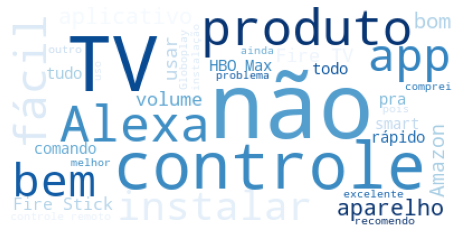

In [19]:
# word cloud nos reviews positivos
pos_rev = ' '.join(df[df['Notas']==1]['controle_review_longo'].to_list()[:10000])
plot_wordcloud(pos_rev, 'Blues')

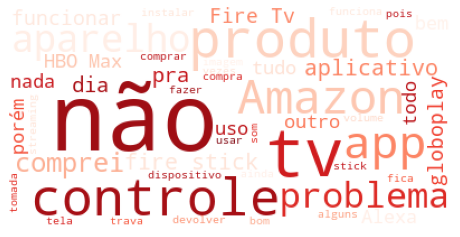

In [20]:
# word cloud nos reviews negativos
neg_rev = ' '.join(df[df['Notas']==0]['controle_review_longo'].to_list()[:10000])
plot_wordcloud(neg_rev, 'Reds')

# Processando os dados

In [21]:
# to remove the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# to remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [22]:
# Processando os reviews
df['controle_review_longo'] = df['controle_review_longo'].apply(remove_URL)
df['controle_review_longo'] = df['controle_review_longo'].apply(remove_html)
df['controle_review_longo'] = df['controle_review_longo'].str.lower()

df['controle_review_longo'] = df['controle_review_longo'].apply(remove_stopwords)

df.head()

,controle_review_longo,data,nota,Notas
0,sensacional! modelo tv primeiras smarts imagem...,2021-05-10,5,1
1,devo dizer bem decepcionado. comprei produto f...,2021-07-13,2,0
2,comprei modelo justamente botões volume power ...,2021-05-15,3,1
3,"pow, amazon, isso? vcs tão competentes coma en...",2021-09-27,1,0
4,pontos positivos: processo instalação bem orie...,2021-05-17,5,1


Reviews e Avaliações

In [23]:
# container for sentences
reviews = np.array([review for review in df['controle_review_longo']])

# container for labels
labels = np.array([label for label in df['Notas']])

Separando dados em treino e teste

In [34]:
# Usando train-test split
from sklearn.model_selection import train_test_split

train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(reviews, labels, 
                                                                                test_size=0.20, 
                                                                                stratify=labels)

Toquenizando os reviews

In [35]:
max_length = 220
vocab_size = 10000
embedding_dim = 100    
print(max_length)

220


In [36]:
# Toquenizando as sentenças
tokenizer = Tokenizer(num_words = vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', oov_token="<OOV>")
tokenizer.fit_on_texts(df['controle_review_longo'].values)
word_index = tokenizer.word_index
print('Quantidade total de palavras toquenizadas:',len(word_index))

# Convertendo o conjunto de treinamendo e adicionando o padding
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

# Convertendo o conjunto de validação e adicionando o padding
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding='post', maxlen=max_length)


Quantidade total de palavras toquenizadas: 5930


In [37]:
train_padded.shape

(1208, 220)

In [38]:
validation_padded.shape

(302, 220)

# Definindo a função de plot da accuracy e loss

In [39]:
def plot_history(history):
    
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='green', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orangered', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='green', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orangered', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Modelo LSTM 

In [84]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 220, 100)          1000000   
                                                                 
 bidirectional_20 (Bidirecti  (None, 128)              84480     
 onal)                                                           
                                                                 
 dense_28 (Dense)            (None, 24)                3096      
                                                                 
 dropout_10 (Dropout)        (None, 24)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,087,601
Trainable params: 1,087,601
Non-trainable params: 0
___________________________________________

In [80]:
from keras.callbacks import EarlyStopping

# fit model
num_epochs = 20
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.001)])

# predict values
pred = model.predict(validation_padded)

Epoch 1/20
31/31 - 16s - loss: 0.4413 - accuracy: 0.8861 - val_loss: 0.3040 - val_accuracy: 0.9091 - 16s/epoch - 526ms/step
Epoch 2/20
31/31 - 13s - loss: 0.2937 - accuracy: 0.9130 - val_loss: 0.2879 - val_accuracy: 0.9091 - 13s/epoch - 411ms/step
Epoch 3/20
31/31 - 13s - loss: 0.2157 - accuracy: 0.9203 - val_loss: 0.2573 - val_accuracy: 0.9174 - 13s/epoch - 418ms/step
Epoch 4/20
31/31 - 13s - loss: 0.0798 - accuracy: 0.9720 - val_loss: 0.3360 - val_accuracy: 0.9091 - 13s/epoch - 419ms/step
Epoch 5/20
31/31 - 12s - loss: 0.0308 - accuracy: 0.9928 - val_loss: 0.3403 - val_accuracy: 0.9008 - 12s/epoch - 397ms/step
Epoch 6/20
31/31 - 13s - loss: 0.0178 - accuracy: 0.9959 - val_loss: 0.5156 - val_accuracy: 0.9091 - 13s/epoch - 408ms/step


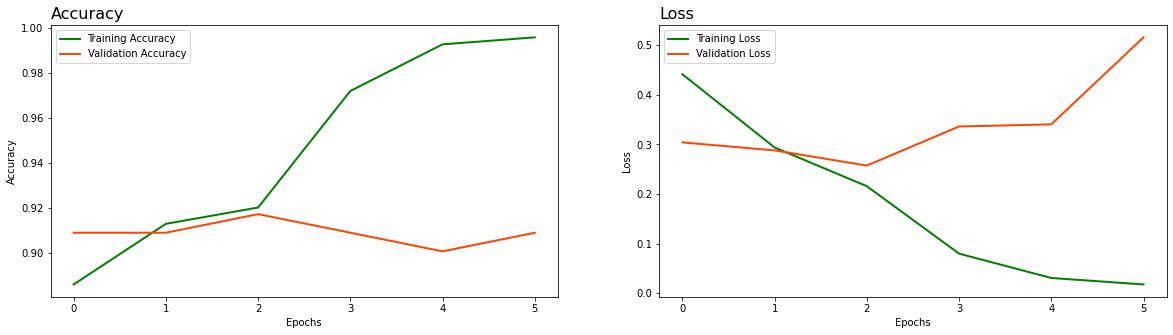

In [85]:
# Plotando os resultados
plot_history(history)

# Modelo CNN

In [61]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 220, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 216, 128)          64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_14 (Dense)            (None, 24)                3096      
                                                                 
 dense_15 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,067,249
Trainable params: 1,067,249
Non-trainable params: 0
____________________________________________

In [62]:
# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.33)

# predict values
pred = model.predict(validation_padded)

Epoch 1/10
26/26 - 2s - loss: 0.4719 - accuracy: 0.8727 - val_loss: 0.3086 - val_accuracy: 0.9073 - 2s/epoch - 88ms/step
Epoch 2/10
26/26 - 2s - loss: 0.2929 - accuracy: 0.9147 - val_loss: 0.3050 - val_accuracy: 0.9073 - 2s/epoch - 63ms/step
Epoch 3/10
26/26 - 2s - loss: 0.2707 - accuracy: 0.9147 - val_loss: 0.3007 - val_accuracy: 0.9073 - 2s/epoch - 63ms/step
Epoch 4/10
26/26 - 2s - loss: 0.2480 - accuracy: 0.9147 - val_loss: 0.2901 - val_accuracy: 0.9073 - 2s/epoch - 68ms/step
Epoch 5/10
26/26 - 2s - loss: 0.1940 - accuracy: 0.9147 - val_loss: 0.2666 - val_accuracy: 0.9073 - 2s/epoch - 72ms/step
Epoch 6/10
26/26 - 2s - loss: 0.1176 - accuracy: 0.9234 - val_loss: 0.2535 - val_accuracy: 0.9073 - 2s/epoch - 75ms/step
Epoch 7/10
26/26 - 2s - loss: 0.0587 - accuracy: 0.9951 - val_loss: 0.2783 - val_accuracy: 0.9123 - 2s/epoch - 71ms/step
Epoch 8/10
26/26 - 2s - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.2760 - val_accuracy: 0.9198 - 2s/epoch - 63ms/step
Epoch 9/10
26/26 - 2s - loss: 0.

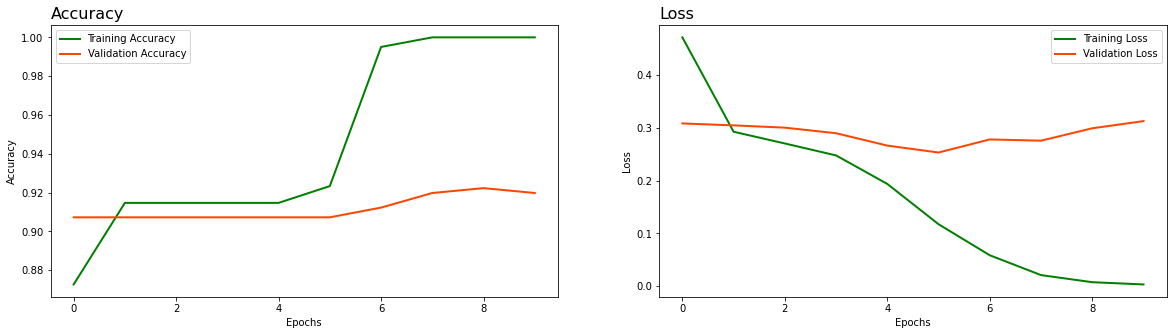

In [63]:
# plot history
plot_history(history)

# A partir daqui só têm análises de testes
Possivelmente serão excluídas.
Estão aqui só para verificar algumas possibilidades.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Codificando o texto em linguagem natural

In [ ]:
# Toquenização
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

tokenized_sents = [word_tokenize(i) for i in df['controle_review_longo'].values]

# Representação de palavras usando o Word2Vec
from gensim.models import Word2Vec
model_review = Word2Vec(tokenized_sents, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Separando dados de entrado e de saída (labels)
X, y = [], []
max_len = 0

for i, row in df.iterrows():
    vetores = model_review.wv[word_tokenize(row['controle_review_longo'])]

    max_len = max(max_len, len(vetores))
    X.append(vetores)
    y.append(row['Notas'])
print("max_len: {}".format(max_len))

In [ ]:
def transform(exemplos, dimension):
    results = np.zeros((len(exemplos), dimension, 100))
    for i, sequence in enumerate(exemplos):
        results[i, :len(sequence), :] = sequence
    return results
 
X = transform(X, max_len)
y = np.array(y).astype("float32")

In [ ]:
np.unique(y)

In [ ]:
X.shape

In [ ]:
max_len

Dividindo dados em treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Difinindo a rede

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

model = Sequential()
model.add(Flatten(input_shape=(max_len, 100)))
model.add(Dense(1000, activation='relu')),
model.add(Dropout(0.3))
model.add(Dense(1000, activation='relu')),
model.add(Dropout(0.3))
model.add(Dense(1000, activation='relu')),
model.add(Dense(3, activation='softmax'))
model.summary()

In [ ]:
model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"]
              )

In [ ]:
results = model.fit(X_train, y_train,
                    epochs= 5,
                    batch_size = 100,
                    validation_data = (X_test, y_test)
                    )

LSTM

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

n_most_common_words = 8000
max_len = max_len
tokenizer = Tokenizer(num_words=n_most_common_words, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(df['controle_review_longo'].values)
sequences = tokenizer.texts_to_sequences(df['controle_review_longo'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len, padding='post')

In [ ]:
y = np.array(y).astype("int64")
labels = to_categorical(y, num_classes=2)
print(labels[:10])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [ ]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

In [ ]:
from keras.callbacks import EarlyStopping

print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc"])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=7, min_delta=0.001)])

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, 64),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(16, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
          optimizer=tf.keras.optimizers.Adam(1e-4),
          metrics=['accuracy'])
model.summary()

history = model.fit(train_padded, training_label_seq, epochs=6,
                validation_data=(validation_padded, validation_label_seq),
                validation_steps=30)